In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [19]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Path to the directory containing the dataset
dataset_path = '/kaggle/input/leapgestrecog/leapGestRecog'

# Initializing lists to hold image data and corresponding labels
data = []
labels = []

# Defining a list of gesture labels that correspond to the classes in the dataset
gesture_labels = ['palm', 'l', 'fist', 'fist_moved', 'thumb', 'index', 'ok', 'palm_moved', 'c', 'down']


In [20]:
# Loop through the subdirectories of the dataset (e.g., 00, 01, 02, etc.)
for folder in os.listdir(dataset_path):
    class_folder = os.path.join(dataset_path, folder)
    
    # Loop through gesture classes (e.g., 01_palm, 02_l, etc.)
    for i, class_name in enumerate(os.listdir(class_folder)):
        img_folder = os.path.join(class_folder, class_name)

        # Loop through the images in each class
        for img_name in os.listdir(img_folder):
            img_path = os.path.join(img_folder, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale mode

            # Check if the image is valid
            if img is None:
                print(f"Error loading image: {img_path}")
                continue

            try:
                # Resize the image to 128x128 pixels
                img_resized = cv2.resize(img, (128, 128))
                data.append(img_resized)
                labels.append(i)  # Use the index of the gesture as the label
            except Exception as e:
                print(f"Error resizing image: {img_path} - {str(e)}")
                continue

# Convert the image data and labels into NumPy arrays
data = np.array(data)
labels = np.array(labels)

# Reshape the data to be compatible with CNN input
data = data.reshape(-1, 128, 128, 1)

# Normalize the image data (values between 0 and 1)
data = data / 255.0

# Convert labels to one-hot encoding format
labels = to_categorical(labels, num_classes=len(gesture_labels))


In [21]:
# Split the data into training and testing sets
# 80% of the data will be used for training, and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)


In [22]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(gesture_labels), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [23]:
# Add EarlyStopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=64, callbacks=[early_stopping])


Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 196s 779ms/step - accuracy: 0.6753 - loss: 0.9626 - val_accuracy: 0.9962 - val_loss: 0.0152
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 191s 764ms/step - accuracy: 0.9810 - loss: 0.0551 - val_accuracy: 0.9985 - val_loss: 0.0052
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 203s 768ms/step - accuracy: 0.9893 - loss: 0.0317 - val_accuracy: 0.9983 - val_loss: 0.0050
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 192s 769ms/step - accuracy: 0.9865 - loss: 0.0342 - val_accuracy: 0.9992 - val_loss: 0.0026
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 193s 774ms/step - accuracy: 0.9930 - loss: 0.0231 - val_accuracy: 0.9995 - val_loss: 0.0021


In [24]:
# Evaluate the model's performance on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")


125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - accuracy: 0.9998 - loss: 5.9420e-04
Test Accuracy: 0.9994999766349792


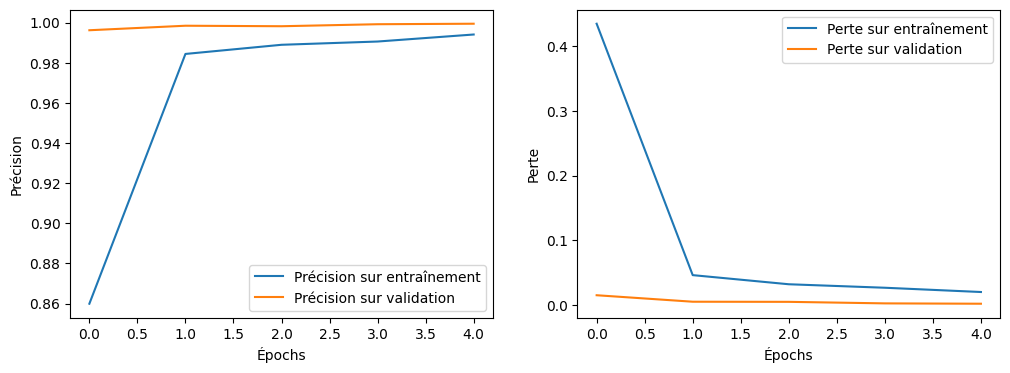

In [25]:
# Plotting the accuracy curve
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Précision sur entraînement')
plt.plot(history.history['val_accuracy'], label='Précision sur validation')
plt.xlabel('Épochs')
plt.ylabel('Précision')
plt.legend()

# Plotting the loss curve
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Perte sur entraînement')
plt.plot(history.history['val_loss'], label='Perte sur validation')
plt.xlabel('Épochs')
plt.ylabel('Perte')
plt.legend()

plt.show()
